In [1]:
!pip install dmba
import dmba
import pandas as pd
import math
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pylab as plt
from dmba import classificationSummary, liftChart, gainsChart

no display found. Using non-interactive Agg backend


In [2]:
cabs_df = pd.read_csv('Taxi-cancellation-case.csv')

In [3]:
cabs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   row#                 10000 non-null  int64  
 1   user_id              10000 non-null  int64  
 2   vehicle_model_id     10000 non-null  int64  
 3   package_id           1752 non-null   float64
 4   travel_type_id       10000 non-null  int64  
 5   from_area_id         9985 non-null   float64
 6   to_area_id           7909 non-null   float64
 7   from_city_id         3706 non-null   float64
 8   to_city_id           339 non-null    float64
 9   from_date            10000 non-null  object 
 10  to_date              5822 non-null   object 
 11  online_booking       10000 non-null  int64  
 12  mobile_site_booking  10000 non-null  int64  
 13  booking_created      10000 non-null  object 
 14  from_lat             9985 non-null   float64
 15  from_long            9985 non-null   

In [4]:
cabs_df.head()

,row#,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,1,17712,12,NaN,2,1021.0,1323.0,NaN,NaN,1/1/13 22:33,NaN,0,0,1/1/13 8:01,13.028530,77.54625,12.869805,77.653211,0
1,2,17037,12,NaN,2,455.0,1330.0,NaN,NaN,1/1/13 12:43,NaN,0,0,1/1/13 9:59,12.999874,77.67812,12.953434,77.706510,0
2,3,761,12,NaN,2,814.0,393.0,NaN,NaN,1/2/13 0:28,1/3/13 0:00,1,0,1/1/13 12:14,12.908993,77.68890,13.199560,77.706880,0
3,4,868,12,NaN,2,297.0,212.0,NaN,NaN,1/1/13 13:12,NaN,0,0,1/1/13 12:42,12.997890,77.61488,12.994740,77.607970,0
4,5,21716,28,NaN,2,1237.0,330.0,NaN,NaN,1/1/13 16:33,NaN,0,0,1/1/13 15:07,12.926450,77.61206,12.858833,77.589127,0


In [5]:
cabs_df.dropna(subset=['from_area_id','to_area_id'], inplace = True)

In [6]:
cabs_df['from_date_dow'] = pd.to_datetime(cabs_df['from_date']).dt.weekday

In [7]:
cabs_df['booking_created_dow'] = pd.to_datetime(cabs_df['booking_created']).dt.weekday

In [8]:
cabs_df['Distance'] = cabs_df.apply(lambda row: (row.from_lat-row.to_lat)**2+(row.from_long-row.to_long)**2, axis = 1)

In [9]:
cabs_df.head()

,row#,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,...,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation,from_date_dow,booking_created_dow,Distance
0,1,17712,12,NaN,2,1021.0,1323.0,NaN,NaN,1/1/13 22:33,...,0,1/1/13 8:01,13.028530,77.54625,12.869805,77.653211,0,1,1,0.036634
1,2,17037,12,NaN,2,455.0,1330.0,NaN,NaN,1/1/13 12:43,...,0,1/1/13 9:59,12.999874,77.67812,12.953434,77.706510,0,1,1,0.002963
2,3,761,12,NaN,2,814.0,393.0,NaN,NaN,1/2/13 0:28,...,0,1/1/13 12:14,12.908993,77.68890,13.199560,77.706880,0,2,1,0.084752
3,4,868,12,NaN,2,297.0,212.0,NaN,NaN,1/1/13 13:12,...,0,1/1/13 12:42,12.997890,77.61488,12.994740,77.607970,0,1,1,0.000058
4,5,21716,28,NaN,2,1237.0,330.0,NaN,NaN,1/1/13 16:33,...,0,1/1/13 15:07,12.926450,77.61206,12.858833,77.589127,0,1,1,0.005098


In [10]:
predictors = ['from_area_id','to_area_id','travel_type_id','online_booking','mobile_site_booking','from_date_dow','booking_created_dow','Distance']
outcome = 'Car_Cancellation'

In [11]:
# partition data
X = cabs_df[predictors]
y = cabs_df[outcome]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.4, random_state = 1)

In [12]:
# Logistic Regression model
logit_reg = LogisticRegression()

In [13]:
logit_reg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [14]:
classificationSummary(y_valid, logit_reg.predict(X_valid))

Confusion Matrix (Accuracy 0.9241)

       Prediction
Actual    0    1
     0 2924    0
     1  240    0


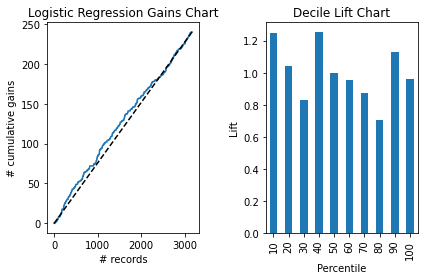

In [15]:
lr_predictiondf = pd.DataFrame({'predicted': logit_reg.predict(X_valid), 'actual': y_valid})

lr_df = lr_predictiondf.sort_values(by=['predicted'], ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(lr_df['actual'], ax=axes[0])
ax.set_title('Logistic Regression Gains Chart')

ax = liftChart(lr_df['actual'], ax=axes[1], labelBars=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()

In [16]:
# While the accuracy is high, the model is not very useful as it does not classify any entries as a 1

In [17]:
# Linear Discriminant Analysis model
lda = LinearDiscriminantAnalysis()

In [18]:
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [19]:
classificationSummary(y_valid, lda.predict(X_valid))

Confusion Matrix (Accuracy 0.9241)

       Prediction
Actual    0    1
     0 2924    0
     1  240    0


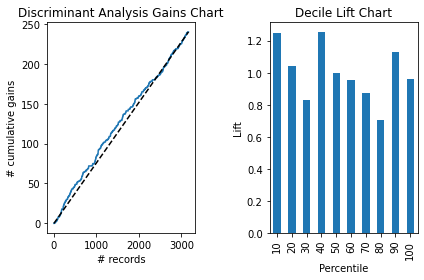

In [20]:
lda_predictiondf = pd.DataFrame({'predicted': lda.predict(X_valid), 'actual': y_valid})

lda_df = lda_predictiondf.sort_values(by=['predicted'], ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(lda_df['actual'], ax=axes[0])
ax.set_title('Discriminant Analysis Gains Chart')

ax = liftChart(lda_df['actual'], ax=axes[1], labelBars=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()

In [21]:
# While the accuracy is high, the model is not very useful as it does not classify any entries as a 1

In [22]:
# Neural Net model
mlpc = MLPClassifier()

In [23]:
mlpc.fit(X_train, y_train)

MLPClassifier()

In [24]:
classificationSummary(y_valid, mlpc.predict(X_valid))

Confusion Matrix (Accuracy 0.9210)

       Prediction
Actual    0    1
     0 2913   11
     1  239    1


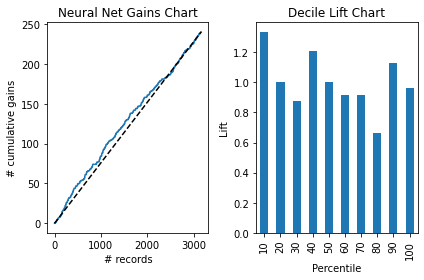

In [25]:
mlpc_predictiondf = pd.DataFrame({'predicted': mlpc.predict(X_valid), 'actual': y_valid})

mlpc_df = mlpc_predictiondf.sort_values(by=['predicted'], ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(mlpc_df['actual'], ax=axes[0])
ax.set_title('Neural Net Gains Chart')

ax = liftChart(mlpc_df['actual'], ax=axes[1], labelBars=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()

In [26]:
# This is some progress! Although the accuracy is ower than the other 2 models, this model does correctly identify some records as being 1!

In [27]:
# k-nearest neighbors model, 3 neighbors
knn = KNeighborsClassifier(n_neighbors=3)

In [28]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [29]:
classificationSummary(y_valid, knn.predict(X_valid))

Confusion Matrix (Accuracy 0.9071)

       Prediction
Actual    0    1
     0 2852   72
     1  222   18


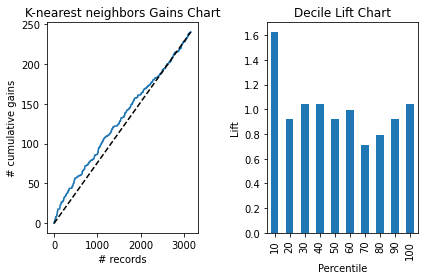

In [30]:
knn_predictiondf = pd.DataFrame({'predicted': knn.predict(X_valid), 'actual': y_valid})

knn_df = knn_predictiondf.sort_values(by=['predicted'], ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(knn_df['actual'], ax=axes[0])
ax.set_title('K-nearest neighbors Gains Chart')

ax = liftChart(knn_df['actual'], ax=axes[1], labelBars=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()

In [31]:
# Decision Tree Classifier
dec_tree = DecisionTreeClassifier()

In [32]:
dec_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [33]:
classificationSummary(y_valid, dec_tree.predict(X_valid))

Confusion Matrix (Accuracy 0.8723)

       Prediction
Actual    0    1
     0 2708  216
     1  188   52


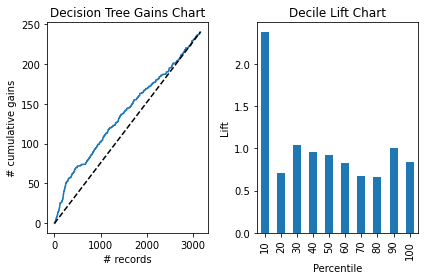

In [34]:
dt_predictiondf = pd.DataFrame({'predicted': dec_tree.predict(X_valid), 'actual': y_valid})

dt_df = dt_predictiondf.sort_values(by=['predicted'], ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(dt_df['actual'], ax=axes[0])
ax.set_title('Decision Tree Gains Chart')

ax = liftChart(dt_df['actual'], ax=axes[1], labelBars=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()

In [35]:
# Random Forest model
rdm_for = RandomForestClassifier()

In [36]:
rdm_for.fit(X_train, y_train)

RandomForestClassifier()

In [37]:
classificationSummary(y_valid, rdm_for.predict(X_valid))

Confusion Matrix (Accuracy 0.9181)

       Prediction
Actual    0    1
     0 2893   31
     1  228   12


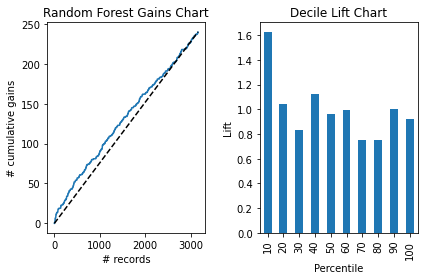

In [38]:
rf_predictiondf = pd.DataFrame({'predicted': rdm_for.predict(X_valid), 'actual': y_valid})

rf_df = rf_predictiondf.sort_values(by=['predicted'], ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(rf_df['actual'], ax=axes[0])
ax.set_title('Random Forest Gains Chart')

ax = liftChart(rf_df['actual'], ax=axes[1], labelBars=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()